<a href="https://colab.research.google.com/github/shaunak-badani/XAI/blob/main/Image-Diffusion-XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from diffusers import DiffusionPipeline
import torch

pipeline = DiffusionPipeline.from_pretrained("segmind/tiny-sd", torch_dtype=torch.float16)
pipeline.to("cuda")
# pipeline("An image of a squirrel in Picasso style").images[0]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--segmind--tiny-sd/snapshots/cad0bd7495fa6c4bcca01b19a723dc91627fe84f/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--segmind--tiny-sd/snapshots/cad0bd7495fa6c4bcca01b19a723dc91627fe84f/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--segmind--tiny-sd/snapshots/cad0bd7495fa6c4bcca01b19a723dc91627fe84f/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--segmind--tiny-sd/snapshots/cad0bd7495fa6c4bcca01b19a723dc91627fe84f/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "segmind/tiny-sd",
  "feature_extractor": [
    null,
    null
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [2]:
# pipeline settings
# pipeline.enable_attention_slicing()
# pipeline.enable_vae_tiling()
# pipeline.enable_model_cpu_offload()

In [3]:
prompt = "An image of a squirrel in Picasso style"
noise = torch.randn((1, 4, 64, 64), dtype=torch.float16, device="cuda")
latents = noise * pipeline.scheduler.init_noise_sigma

for p in pipeline.unet.parameters():
    p.requires_grad = False

text_inputs = pipeline.tokenizer(
    prompt,
    padding="max_length",
    max_length=pipeline.tokenizer.model_max_length,
    return_tensors="pt",
)
text_embeddings = pipeline.text_encoder(text_inputs.input_ids.to("cuda"))[0]

In [4]:
num_inference_steps = 20
pipeline.scheduler.set_timesteps(num_inference_steps, device="cuda")
timesteps = pipeline.scheduler.timesteps

In [5]:
with torch.set_grad_enabled(True):
    for i, t in enumerate(timesteps):
        # Predict noise residual
        print("t: ", t)
        noise_pred = pipeline.unet(latents, t, encoder_hidden_states=text_embeddings).sample

        # Update latents (DDIM or other scheduler step)
        latents = pipeline.scheduler.step(noise_pred, t, latents).prev_sample

    # Now decode latents to get image tensor
    latents = 1 / 0.18215 * latents
    image_tensor = pipeline.vae.decode(latents).sample  # shape: [1, 3, 512, 512]

t:  tensor(999, device='cuda:0')
t:  tensor(949, device='cuda:0')
t:  tensor(899, device='cuda:0')
t:  tensor(849, device='cuda:0')
t:  tensor(799, device='cuda:0')
t:  tensor(749, device='cuda:0')
t:  tensor(699, device='cuda:0')
t:  tensor(649, device='cuda:0')
t:  tensor(599, device='cuda:0')
t:  tensor(549, device='cuda:0')
t:  tensor(500, device='cuda:0')
t:  tensor(450, device='cuda:0')
t:  tensor(400, device='cuda:0')
t:  tensor(350, device='cuda:0')
t:  tensor(300, device='cuda:0')
t:  tensor(250, device='cuda:0')
t:  tensor(200, device='cuda:0')
t:  tensor(150, device='cuda:0')
t:  tensor(100, device='cuda:0')
t:  tensor(50, device='cuda:0')


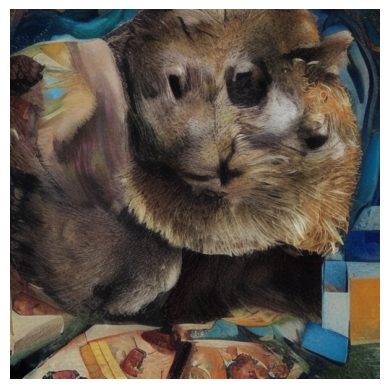

In [6]:
def show_image_from_tensor(img_tensor):
    """
    Displays a single image from a torch tensor.
    Assumes the tensor shape is [1, 3, H, W] or [3, H, W] with values in [-1, 1] or [0, 1].
    """
    import numpy as np
    import matplotlib.pyplot as plt
    # Detach from graph, move to CPU, and remove batch dim if needed
    if img_tensor.dim() == 4:
        img_tensor = img_tensor[0]

    img_tensor = img_tensor.detach().cpu()
    # Convert to float32 if it's float16 (common with AMP/vae.decode)
    if img_tensor.dtype == torch.float16:
        img_tensor = img_tensor.to(torch.float32)

    # If in [-1, 1], convert to [0, 1]
    if img_tensor.min() < 0:
        img_tensor = (img_tensor + 1) / 2

    # Convert to NumPy and rearrange dimensions
    image_np = img_tensor.permute(1, 2, 0).numpy()
    image_np = np.clip(image_np, 0, 1)

    plt.imshow(image_np)
    plt.axis('off')
    plt.show()

show_image_from_tensor(image_tensor)